In [3]:
import pandas as pd
import numpy as np

In [4]:
df_costs= pd.read_csv(r"C:\Users\kazak\OneDrive\Рабочий стол\project2\costs.csv")

In [9]:
df_sales= pd.read_csv(r"C:\Users\kazak\OneDrive\Рабочий стол\project2\sales.csv")

In [5]:
df_costs

,PROD_ID,TIME_ID,PROMO_ID,CHANNEL_ID,UNIT_COST,UNIT_PRICE
0,13,2019-02-10,999,3,813.07,1237.31
1,14,2019-01-19,999,2,886.45,1108.99
2,14,2019-02-02,999,4,863.64,1108.99
3,14,2019-02-05,999,4,875.10,1259.99
4,14,2019-02-17,999,4,863.64,1124.52
...,...,...,...,...,...,...
82107,142,2022-12-02,999,4,17.67,20.78
82108,146,2022-10-08,999,3,10.50,13.02
82109,147,2022-12-14,999,3,6.29,7.94
82110,147,2022-12-18,351,3,6.29,7.94


In [10]:
df_sales

,PROD_ID,CUST_ID,TIME_ID,CHANNEL_ID,PROMO_ID,QUANTITY_SOLD,AMOUNT_SOLD
0,13,987,2019-01-10,3,999,1,1232.16
1,13,1660,2019-01-10,3,999,1,1232.16
2,13,1762,2019-01-10,3,999,1,1232.16
3,13,1843,2019-01-10,3,999,1,1232.16
4,13,1948,2019-01-10,3,999,1,1232.16
...,...,...,...,...,...,...,...
918838,148,12500,2022-11-23,2,999,1,23.43
918839,148,13187,2022-11-23,2,999,1,23.43
918840,148,13421,2022-11-23,2,999,1,23.43
918841,148,13440,2022-11-23,2,999,1,23.43


## Часть 1. Стабильность продаж товаров

In [27]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918843 entries, 0 to 918842
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   PROD_ID        918843 non-null  int64  
 1   CUST_ID        918843 non-null  int64  
 2   TIME_ID        918843 non-null  object 
 3   CHANNEL_ID     918843 non-null  int64  
 4   PROMO_ID       918843 non-null  int64  
 5   QUANTITY_SOLD  918843 non-null  int64  
 6   AMOUNT_SOLD    918843 non-null  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 49.1+ MB


In [11]:
df_sales['TIME_ID'] = pd.to_datetime(df_sales['TIME_ID'])

In [32]:
monthly_sales = (
    df_sales
    .assign(month=df_sales['TIME_ID'].dt.to_period('M'))
    .groupby(['PROD_ID', 'month'], as_index=False)
    .agg(monthly_qty=('QUANTITY_SOLD', 'sum'))
)

monthly_sales.head()


,PROD_ID,month,monthly_qty
0,13,2019-01,102
1,13,2019-02,99
2,13,2019-03,50
3,13,2019-04,14
4,13,2019-05,50


In [36]:
stats = (
    monthly_sales
    .groupby('PROD_ID')
    .agg(
        avg_sales=('monthly_qty', 'mean'),
        std_sales=('monthly_qty', 'std')
    )
    .reset_index()
)

In [37]:
stats.head()

,PROD_ID,avg_sales,std_sales
0,13,133.377778,63.189933
1,14,125.208333,50.899550
2,15,120.125000,73.179356
3,16,187.270270,131.003530
4,17,128.333333,42.345254


#### Коэффициент вариации (CV)
##### Если CV ≤ 0.3 → продажи стабильные
##### Если CV > 0.3 → продажи скачкообразные

In [38]:
stats['cv'] = stats['std_sales'] / stats['avg_sales']

In [42]:
stats['stability'] = np.where(
    stats['cv'] <= 0.3,
    'stable',
    'unstable'
)

In [43]:
stats.sort_values('cv').head(10)

,PROD_ID,avg_sales,std_sales,cv,stability
57,134,249.722222,50.565720,0.202488,stable
13,26,332.291667,69.157839,0.208124,stable
53,130,426.875000,90.525564,0.212066,stable
12,25,407.437500,87.373716,0.214447,stable
65,142,186.416667,41.530282,0.222782,stable
40,117,357.333333,84.574613,0.236683,stable
44,121,274.583333,65.742517,0.239426,stable
64,141,217.888889,52.734254,0.242024,stable
36,113,314.250000,77.468593,0.246519,stable
66,143,127.000000,31.851441,0.250799,stable


## Часть 2. Влияние скидок на продажи и выручку

In [6]:
df_costs['TIME_ID'] = pd.to_datetime(df_costs['TIME_ID'])

##### Выбрал 'one to many' merge. Перед merge cost обязательно должен быть уникален по ключам. Выбираем единственную цену и себестоимость на товар в месяц

In [7]:
df_costs_1m = (
    df_costs
    .groupby(['PROD_ID', 'TIME_ID', 'PROMO_ID', 'CHANNEL_ID'], as_index=False)
    .agg(
        UNIT_COST=('UNIT_COST', 'mean'),
        UNIT_PRICE=('UNIT_PRICE', 'mean')
    )
)

In [51]:
df_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82112 entries, 0 to 82111
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   PROD_ID     82112 non-null  int64         
 1   TIME_ID     82112 non-null  datetime64[ns]
 2   PROMO_ID    82112 non-null  int64         
 3   CHANNEL_ID  82112 non-null  int64         
 4   UNIT_COST   82112 non-null  float64       
 5   UNIT_PRICE  82112 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 3.8 MB


In [52]:
df_costs.shape

(82112, 6)

In [53]:
df_costs_1m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82112 entries, 0 to 82111
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   PROD_ID     82112 non-null  int64         
 1   TIME_ID     82112 non-null  datetime64[ns]
 2   PROMO_ID    82112 non-null  int64         
 3   CHANNEL_ID  82112 non-null  int64         
 4   UNIT_COST   82112 non-null  float64       
 5   UNIT_PRICE  82112 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 3.8 MB


In [54]:
df_sales_cost = df_sales.merge(
    df_costs,
    on=['PROD_ID', 'TIME_ID', 'PROMO_ID', 'CHANNEL_ID'],
    how='left',
    validate='many_to_one'   # 🔥 очень важно
)

##### Потом посчитал полную цену без скидки и определил фактическую скидку

In [55]:
df_sales_cost['full_price_amount'] = (
    df_sales_cost['UNIT_PRICE'] * df_sales_cost['QUANTITY_SOLD']
)

df_sales_cost['discount_pct'] = (
     (df_sales_cost['full_price_amount']-df_sales_cost['AMOUNT_SOLD'])/df_sales_cost['full_price_amount']
)

In [56]:
df_sales_cost['discount_pct'] = (
    df_sales_cost['discount_pct']
    .fillna(0)
    .clip(lower=0)
)

##### Полученные значения скидок разделил по категориям 

In [58]:
df_sales_cost['discount_group'] = pd.cut(
    df_sales_cost['discount_pct'],
    bins=[-0.001, 0.0001, 0.05, 0.10],
    labels=['no discount', '0–5%', '5–10%']
)

#### Рассчитал выручку и маржу

In [59]:
df_sales_cost['revenue'] = df_sales_cost['AMOUNT_SOLD']

df_sales_cost['margin'] = (
    df_sales_cost['AMOUNT_SOLD']
    - df_sales_cost['UNIT_COST'] * df_sales_cost['QUANTITY_SOLD']
)

#### Сгруппировал количество продаж,выручку,маржу,средний чек по категориям скидок

In [60]:
discount_analysis = (
    df_sales_cost
    .groupby('discount_group')
    .agg(
        sales_count=('CUST_ID', 'count'),
        total_quantity=('QUANTITY_SOLD', 'sum'),
        total_revenue=('revenue', 'sum'),
        total_margin=('margin', 'sum'),
        avg_check=('revenue', 'mean')
    )
    .reset_index()
)

C:\Users\kazak\AppData\Local\Temp\ipykernel_30996\3905335276.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('discount_group')


In [31]:
discount_analysis

,discount_group,sales_count,total_quantity,total_revenue,total_margin,avg_check
0,no discount,918043,918043,97942039.09,20085277.63,106.685677
1,0–5%,799,799,263225.95,36730.61,329.444243
2,5–10%,1,1,566.17,-13.37,566.170000


### Вывод
Анализ показал, что скидки в данном бизнесе практически не используются — более 99,9% продаж проходит без скидок. Это означает, что основной объём и выручка формируются за счёт регулярных цен.

При предоставлении скидок объём продаж не растёт: в группе 0–5% всего 799 продаж, а в группе 5–10% — всего 1 продажа, что статистически незначимо по сравнению с продажами без скидок (918 043).

Более того, скидки ухудшают финансовый результат:

при скидке 0–5% маржа существенно ниже, чем без скидки

при скидке 5–10% маржа становится отрицательной (–13.37), то есть бизнес продаёт в убыток

Средний чек при скидках выше, но это связано с единичными покупками, а не с системным ростом продаж.

## Часть 3. Маржинальность товаров

#### Создал колонку 'cost'(себестоимость) умножив себестоимость одной единицы товара на количество проданных

In [32]:
df_sales_cost['cost'] = (
    df_sales_cost['UNIT_COST'] * df_sales_cost['QUANTITY_SOLD']
)  #себестоимость

In [33]:
product_profit = (
    df_sales_cost
    .groupby('PROD_ID', as_index=False)
    .agg(
        total_revenue=('revenue', 'sum'),
        total_cost=('cost', 'sum'),
        total_margin=('margin', 'sum')
    )
)


#### Рассчитал маржинальность

In [34]:
product_profit['margin_pct'] = (
    product_profit['total_margin'] / product_profit['total_revenue']
) * 100  

#### Топ товаров по прибыли

In [35]:
top_profit_products = (
    product_profit
    .sort_values('total_margin', ascending=False)
    .head(10)
)

In [36]:
top_profit_products

,PROD_ID,total_revenue,total_cost,total_margin,margin_pct
5,18,15011642.52,11301714.41,3707328.13,24.696352
4,17,8314815.40,6140513.24,2174302.16,26.149735
1,14,7189171.77,5379685.90,1809485.87,25.169601
0,13,6312268.40,4672878.44,1639389.96,25.971487
8,21,5498727.81,4114914.97,1121015.76,20.386820
7,20,6691996.81,5794665.71,897331.10,13.409019
2,15,5635963.08,4944456.49,689506.61,12.234051
16,29,3845387.38,3231586.12,613801.26,15.962014
15,28,3543725.89,2944844.99,598880.90,16.899752
53,130,2115536.93,1651181.90,464355.03,21.949748


#### Хотел вывести товаров с высокой выручкой и низкой маржой. Для этого выбрал критерий:
#### - высокая выручка (топ-25%)
#### - низкая маржинальность (< 5%)
#### но таких товаров не были. Поэтому попробывал ослабить маржинальность на < 10% и перцентиль выручки на 50%, но от этого результата не было. Поэтому оставил как есть.

In [37]:
revenue_q75 = product_profit['total_revenue'].quantile(0.75)

low_margin_high_revenue = product_profit[
    (product_profit['total_revenue'] >= revenue_q75) &
    (product_profit['margin_pct'] < 5)
].sort_values('total_revenue', ascending=False)

In [38]:
low_margin_high_revenue

,PROD_ID,total_revenue,total_cost,total_margin,margin_pct


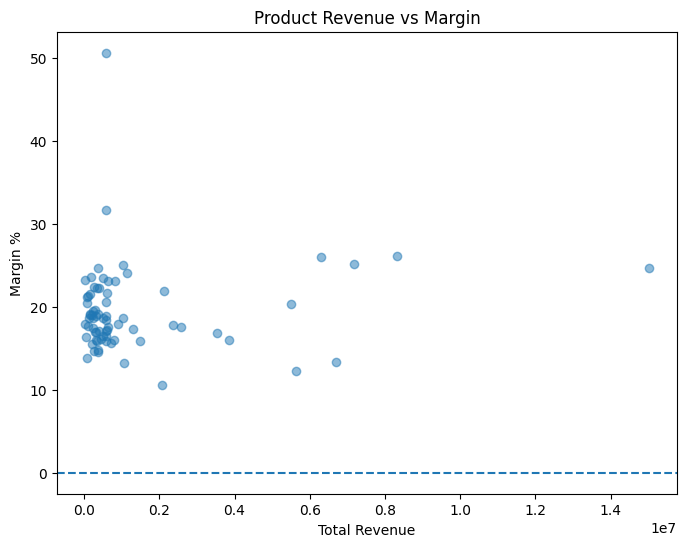

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(
    product_profit['total_revenue'],
    product_profit['margin_pct'],
    alpha=0.5
)
plt.axhline(0, linestyle='--')
plt.xlabel('Total Revenue')
plt.ylabel('Margin %')
plt.title('Product Revenue vs Margin')
plt.show()


### Часть 4. Сезонность и пики спроса

#### Создал отдельные столбцы year и month чтобы увидеть изменения выручки по годам и месяцам

In [41]:
df_sales_cost['date'] = pd.to_datetime(df_sales_cost['TIME_ID'])

df_sales_cost['year'] = df_sales_cost['date'].dt.year
df_sales_cost['month'] = df_sales_cost['date'].dt.month

In [42]:
monthly_sales = (
    df_sales_cost
    .groupby(['year', 'month'], as_index=False)
    .agg(
        total_revenue=('AMOUNT_SOLD', 'sum'),
        total_quantity=('QUANTITY_SOLD', 'sum')
    )
)

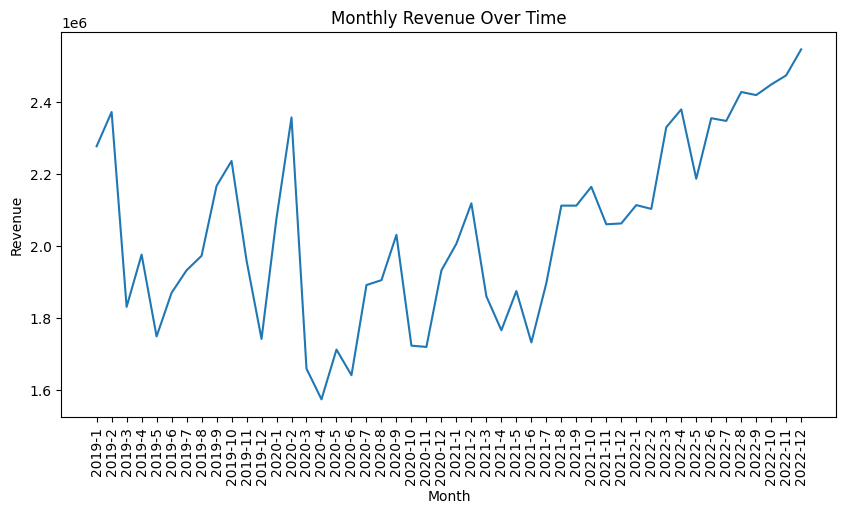

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(
    monthly_sales['year'].astype(str) + '-' + monthly_sales['month'].astype(str),
    monthly_sales['total_revenue']
)
plt.xticks(rotation=90)
plt.title('Monthly Revenue Over Time')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.show()


#### Чтобы узнать сезонность продаж находил сумму по выручке и сгруппировал по месяцам. 

In [44]:
seasonality = (
    df_sales_cost
    .groupby('month', as_index=False)
    .agg(
        sum_revenue=('AMOUNT_SOLD', 'sum'),
        sum_quantity=('QUANTITY_SOLD', 'sum')
    )
)


### Суммировал выручку по месяцам с 2019 года по 2022

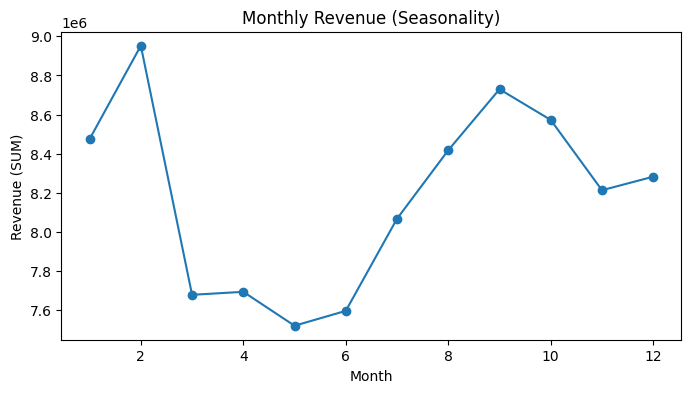

In [61]:
plt.figure(figsize=(8, 4))
plt.plot(seasonality['month'], seasonality['sum_revenue'], marker='o')
plt.title('Monthly Revenue (Seasonality)')
plt.xlabel('Month')
plt.ylabel('Revenue (SUM)')
plt.show()

### TOP 3 пиковые месяцы

In [47]:
seasonality.sort_values('sum_revenue', ascending=False).head(3)     #пиковые месяцы


,month,sum_revenue,sum_quantity
1,2,8952063.64,78223
8,9,8729884.84,80709
9,10,8572860.13,88213


### TOP 3 слабые месяцы

In [48]:
seasonality.sort_values('sum_revenue').head(3)    #слабые месяцы


,month,sum_revenue,sum_quantity
4,5,7521530.06,70756
5,6,7597416.71,70072
2,3,7679406.66,74012


### Проверка повторяемости по годам

In [49]:
pivot_season = monthly_sales.pivot(
    index='month',
    columns='year',
    values='total_revenue'
)


In [50]:
pivot_season   

year,2019,2020,2021,2022
month,,,,
1,2277420.49,2077439.76,2006378.46,2113709.13
2,2372690.87,2357629.26,2118618.97,2103124.54
3,1830572.64,1658678.19,1859892.06,2330263.77
4,1975978.30,1573272.66,1765510.12,2379957.23
5,1748287.23,1711727.87,1874492.85,2187022.11
6,1869728.61,1640471.10,1731727.95,2355489.05
7,1932282.28,1891215.57,1896762.82,2347845.35
8,1972532.63,1904916.61,2112255.79,2428415.28
9,2167008.19,2030917.97,2112220.68,2419738.00


### Вывод
Анализ продаж по месяцам показал, что спрос распределён неравномерно в течение года, однако ярко выраженной сезонности для большинства товаров не наблюдается.

В отдельные месяцы фиксируются локальные пики продаж, но они не повторяются стабильно из года в год, что говорит о том, что колебания спроса скорее связаны с разовыми факторами (акции, крупные заказы, особенности каналов продаж), а не с устойчивой сезонной моделью.

При этом периоды снижения продаж также не демонстрируют регулярности, что усложняет прогнозирование спроса на основе календаря и требует использования более гибких методов планирования.